# <font style = "color:rgb(50,120,229)">Application - Face Alignment</font>

## <font style = "color:rgb(50,120,229)">Overview </font> 
In the previous chapter, we discussed about the 68 point model and its use cases. The first application we talked about was Face Alignment, which is helpful in Face recognition systems. In this chapter we will discuss about a new 5-point landmark detector released by dlib and also how to perform Face Alignment using the model.

## <font style = "color:rgb(50,120,229)">5-point landmark detector in Dlib</font>
In the new 5-point model, the landmark points consists of 2 points at the corners of the eye; for each eye and one point on the nose-tip. It is shown in the image given below.

<center> <img src = "https://www.learnopencv.com/wp-content/uploads/2018/09/fld-5-point-model.jpg" width=500/></center>

&nbsp;
We have included the 5 point model in the `models/` folder.

## <font style = "color:rgb(50,120,229)">Face Alignment Code</font>
In this section we will go over the code used for face alignment using the 5-point model.

First, load the image and landmark model. We will then compute the landmarks.

In [2]:
import dlib
import cv2
import numpy as np
import faceBlendCommon as fbc
from dataPath import DATA_PATH
from dataPath import MODEL_PATH
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [4]:
# Landmark model location
PREDICTOR_PATH = MODEL_PATH + "shape_predictor_5_face_landmarks.dat"

In [5]:
# Get the face detector
faceDetector = dlib.get_frontal_face_detector()
# The landmark detector is implemented in the shape_predictor class
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

In [6]:
# Read image
im = cv2.imread(DATA_PATH + "images/face1.png")

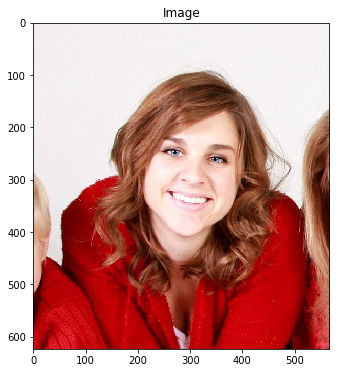

In [7]:
plt.imshow(im[:,:,::-1])
plt.title("Image")
plt.show()

In [8]:
# Detect landmarks.
points = fbc.getLandmarks(faceDetector, landmarkDetector, im)

In [9]:
points = np.array(points)
print(points)

[[365 266]
 [334 262]
 [254 248]
 [287 254]
 [304 315]]


In [10]:
# Convert image to floating point in the range 0 to 1
im = np.float32(im)/255.0

Specify the size of the aligned face image. Compute the normalized image by using the similarity transform.

In [11]:
# Dimensions of output image
h = 600
w = 600

In [12]:
def similarityTransform(inPoints, outPoints):
    s60 = math.sin(60*math.pi/180)
    c60 = math.cos(60*math.pi/180)
    
    inPts = np.copy(inPoints).tolist()
    outPts = np.copy(outPoints).tolist()

  # The third point is calculated so that the three points make an equilateral triangle
    xin = c60*(inPts[0][0] - inPts[1][0]) - s60*(inPts[0][1] - inPts[1][1]) + inPts[1][0]
    yin = s60*(inPts[0][0] - inPts[1][0]) + c60*(inPts[0][1] - inPts[1][1]) + inPts[1][1]
    
    inPts.append([np.int(xin), np.int(yin)])
    xout = c60*(outPts[0][0] - outPts[1][0]) - s60*(outPts[0][1] - outPts[1][1]) + outPts[1][0]
    yout = s60*(outPts[0][0] - outPts[1][0]) + c60*(outPts[0][1] - outPts[1][1]) + outPts[1][1]
    
    outPts.append([np.int(xout), np.int(yout)])

  # Now we can use estimateRigidTransform for calculating the similarity transform.
    tform = cv2.estimateAffinePartial2D(np.array([inPts]), np.array([outPts]))
    return tform[0]

In [17]:
# Normalize image to output coordinates.
normalizeImagesAndLandmarks((h, w), im, points)

[[365 266]
 [334 262]
 [254 248]
 [287 254]
 [304 315]]
[array([254, 248]), array([365, 266])]


NameError: name 'math' is not defined

In [17]:
imNorm = np.uint8(imNorm*255)

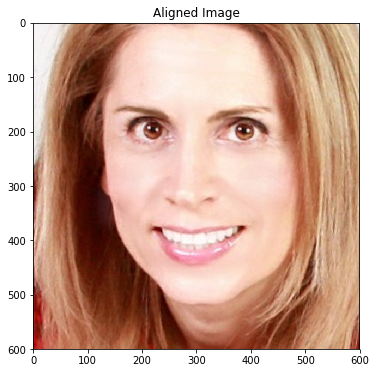

In [18]:
# Display the results
plt.imshow(imNorm[:,:,::-1])
plt.title("Aligned Image")
plt.show()

### <font style="color:rgb(8,133,37)">Image Alignment Code </font>

This is the function that performs the alignment.

It Normalizes a facial image to a standard size given by `outSize`. The normalization is done based on Dlib’s landmark points passed as `pointsIn`.

After the normalization the left corner of the left eye is at `(0.3 * w, h/3 )` and the right corner of the right eye is at `( 0.7 * w, h / 3)` where `w` and `h` are the width and height of outSize.

It also checks if the model is a 68 point model or 5 point model.

In [16]:
def normalizeImagesAndLandmarks(outSize, imIn, pointsIn):
    h, w = outSize
    print(pointsIn)
  # Corners of the eye in input image
    if len(pointsIn) == 68:
        eyecornerSrc = [pointsIn[36], pointsIn[45]]
    elif len(pointsIn) == 5:
        eyecornerSrc = [pointsIn[2], pointsIn[0]]
    print(eyecornerSrc)
  # Corners of the eye in normalized image
    eyecornerDst = [(np.int(0.3 * w), np.int(h/3)),
                  (np.int(0.7 * w), np.int(h/3))]

  # Calculate similarity transform
    tform = similarityTransform(eyecornerSrc, eyecornerDst)
    imOut = np.zeros(imIn.shape, dtype=imIn.dtype)

  # Apply similarity transform to input image
    imOut = cv2.warpAffine(imIn, tform, (w, h))

  # reshape pointsIn from numLandmarks x 2 to numLandmarks x 1 x 2
    points2 = np.reshape(pointsIn, (pointsIn.shape[0], 1, pointsIn.shape[1]))

  # Apply similarity transform to landmarks
    pointsOut = cv2.transform(points2, tform)

  # reshape pointsOut to numLandmarks x 2
    pointsOut = np.reshape(pointsOut, (pointsIn.shape[0], pointsIn.shape[1]))
    return imOut, pointsOut

## <font style = "color:rgb(50,120,229)">Results</font>

| <center><img src="https://www.learnopencv.com/wp-content/uploads/2018/09/cv4f-mod3.2-face2.png"/></center> | <center><img src="https://www.learnopencv.com/wp-content/uploads/2018/09/cv4f-mod-3.2-AlignedFace.jpg"/></center> |
| -------- | -------- | 
| <center><img src="https://www.learnopencv.com/wp-content/uploads/2018/09/cv4f-mod3.2-face1.png"/></center> | <center><img src="https://www.learnopencv.com/wp-content/uploads/2018/09/cv4f-mod-3.2-AlignedFace1.jpg"/></center> |
|<center>Original Image</center> | <center>Aligned Face</center> |

# <font style = "color:rgb(50,120,229)">References and Further Reading</font>

1. https://melgor.github.io/blcv.github.io/static/2017/12/28/demystifying-face-recognition-iii-face-preprocessing/
2. https://github.com/luoyetx/face-alignment-at-3000fps